# 二項係数・組み合わせ

https://drken1215.hatenablog.com/entry/2018/06/08/210000

## 二項係数

[二項係数](https://ja.wikipedia.org/wiki/%E4%BA%8C%E9%A0%85%E4%BF%82%E6%95%B0) (binomial coefficient) は、$(1+x)^n$ を展開した時に現れる係数のこと。  
$_n\mathrm{C}_k$ または $\binom{n}{k}$ と表記する。
$$
\begin{eqnarray}
(1+x)^0 &=& 1 \\
(1+x)^1 &=& 1 + x \\
(1+x)^2 &=& 1 + 2x + x^2 \\
(1+x)^3 &=& 1 + 3x + 3x^2 + x^3 \\
&\vdots& \\
(1+x)^n &=& _n\mathrm{C}_0x^0 + _n\mathrm{C}_1x + _n\mathrm{C}_2x^2 + \ldots + _n\mathrm{C}_nx^n \\
&=& \sum^{n}_{k=0} \binom{n}{k} x^k
\end{eqnarray}
$$

二項係数は組み合わせ (combinations) の数でもある。  
二項係数は「$n$個の中から$k$個を選ぶ組み合わせの総数」「$n$個の中から$k$個を選ぶ場合の数」と言い換えることができる。
$$
\begin{eqnarray}
_n\mathrm{C}_k = \frac{_n\mathrm{P}_k}{k!} = \frac{n!}{k!(n-k)!}
\end{eqnarray}
$$

## 性質
次の等式が成り立つ。
$$
\begin{eqnarray}
\binom{n}{k} &=& \binom{n}{n-k} \\
\end{eqnarray}
$$
次の漸化式が成り立つ。
$$
\begin{eqnarray}
\binom{n}{0} &=& 1 \\
\binom{n}{k} &=& \begin{cases}
    0 & (k > n) \\
    \binom{n-1}{k-1} + \binom{n-1}{k} & (k <= n) \\
\end{cases}
\end{eqnarray}
$$

In [1]:
import numpy as np
N = 5
dp = np.zeros((N+1, N+1), dtype=np.int)
dp[:, 0] = 1
for n in range(1, N+1):
    for k in range(1, n+1):
        dp[n, k] = dp[n-1, k-1] + dp[n-1, k]

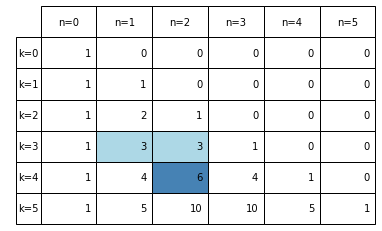

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
cellColours = [['w' for k in range(N+1)] for n in range(N+1)]
cellColours[3][1] = 'lightblue'
cellColours[3][2] = 'lightblue'
cellColours[4][2] = 'steelblue'
ax.table(dp,
    rowLabels=["k={}".format(i) for i in range(N+1)],
    colLabels=["n={}".format(i) for i in range(N+1)],
    loc='center',
    bbox=[0.1, 0, 1, 1],
    cellColours=cellColours)
ax.axis('off')
plt.show()

## 組み合わせの全列挙・数え上げ

$_n\mathrm{C}_k$ で表される組み合わせを列挙するには `itertools.combinations(iterable, r)` を用いる。  
`iterable` には長さ$n$のリストを渡す。

In [3]:
N = 5
K = 2
seq = list(range(N))
print(seq)

[0, 1, 2, 3, 4]


In [4]:
from itertools import combinations

# N=5個の数字からK=2個の数字を取り出すときの、全ての組み合わせ (10通り) を列挙する
print([p for p in combinations(seq, K)])

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


## 二項係数の計算

ここでは $_n\mathrm{C}_k \pmod{p}$ の計算方法を扱う。

### 方法1

$\min(k, n-k) \leq 10^6$ 程度まで対応可能。

$$
\begin{eqnarray}
    \binom{n}{k} &=& \frac{n!}{k!(n-k)!} = \frac{n(n-1) \ldots (n-k+1)}{k(k-1) \ldots 1} \\
    &=& \left( \prod_{i=1}^{k} n-k+i \right) \left( \prod_{i=1}^{k} i \right)^{-1}
\end{eqnarray}
$$

分母と分子を別々に計算し、それらの商をとる。  
分母、分子はいずれも$k$回のループで求まるので、全体の計算量はクエリ毎に$\mathcal{O}(k)$。

In [5]:
def binom(n, k, MOD=10**9+7):
    k = min(k, n-k)
    a = 1
    for i in range(n-k+1, n+1):
        a = a * i % MOD
    b = 1
    for i in range(1, k+1):
        b = b * i % MOD
    return a * pow(b, MOD-2, MOD) % MOD

In [6]:
binom(10, 4)

210

In [7]:
binom(10**12, 10**6)

344082972

### 方法2

$n$が小さければ、方法1に比べてさらに高速化できる。  
$n \leq 10^6$ 程度まで対応可能。

$$\binom{n}{k} = \frac{n!}{k!(n-k)!} = n!(k!)^{-1}((n-k)!)^{-1}$$

$n$以下の全ての$k'$に対して$k'!, (k'!)^{-1}$ の2種類の値を事前計算しておくことで、クエリ毎に$\mathcal{O}(1)$で計算可能となる。

$k'!$については逐次計算し、その値を記憶しておく。

$(k'!)^{-1}$の計算については、逆元を使って求めると計算量は$\mathcal{O}(\log(p))$となる。  

In [8]:
def binom_preprocess(n, MOD=10**9+7):
    f = [0 for i in range(n+1)]  # n!
    invf = [0 for i in range(n+1)]  # (n!)^-1
    f[0] = 1
    f[1] = 1
    invf[0] = 1
    invf[1] = 1
    for i in range(2, n+1):
        f[i] = f[i-1] * i % MOD
        invf[i] = pow(f[i], MOD-2, MOD)
    return f, invf

def binom(n, k, f, invf, MOD=10**9+7):
    if n < k or n < 0 or k < 0:
        return 0
    else:
        return (f[n] * invf[k] % MOD) * invf[n-k] % MOD

前処理の `pow(f[i], p-2, p)` を含むループはさらに計算量を落とすことができる。  
$a_k = (k!)^{-1}$ とおけば、漸化式 $a_{k-1} = k \cdot a_k$ が成り立つので、 $a_n = (n!)^{-1}$ だけ計算すれば他は漸化式から求まる。

計算量は事前計算に$\mathcal{O}(n)$、クエリ毎に$\mathcal{O}(1)$。

In [9]:
def binom_preprocess(n, MOD=10**9+7):
    f = [0 for i in range(n+1)]  # n!
    invf = [0 for i in range(n+1)]  # (n!)^-1
    f[0] = 1
    f[1] = 1
    invf[0] = 1
    invf[1] = 1
    for i in range(2, n+1):
        f[i] = f[i-1] * i % MOD
    invf[n] = pow(f[n], MOD-2, MOD)
    for i in range(n, 2, -1):
        invf[i-1] = invf[i] * i % MOD
    return f, invf

def binom(n, k, f, invf, MOD=10**9+7):
    if n < k or n < 0 or k < 0:
        return 0
    else:
        return (f[n] * invf[k] % MOD) * invf[n-k] % MOD

In [10]:
f, invf = binom_preprocess(10**6)

In [11]:
binom(10**6, 4, f, invf)

85121780